## Introduction

This project analyzes the monthly activity of users in an educational application similar to Duolingo, covering **January 2024**.
The main objective was to understand user behavior patterns, compare the activity of **Premium** and **Free** users, and finally, segment users based on their monthly engagement using a **K-Means clustering model**.

This analysis provides insights that can support **retention**, **engagement**, and **content personalization** strategies—key elements in digital education platforms.

---

## 1. Data Cleaning

The dataset’s structure was reviewed to ensure that:

* Dates were properly formatted (`yyyy-mm-dd`),
* No negative values existed in numeric columns (`lessons_completed`, `minutes_spent`, `quizzes_attempted`).

Results confirmed that the dataset was **well-structured and clean**, ready for use in analysis.

*Note:* Duplicate rows were not removed, as each record represented a daily user activity.

---

## 2. Daily Exploratory Analysis

Descriptive statistics showed that:

* 75% of users completed **one or fewer lessons per day**.
* 75% spent **less than 43 minutes per day** using the app.
* Most users **did not attempt quizzes** daily.

Distribution and boxplot visualizations revealed **outliers** — users completing more than 5 lessons or 2 quizzes per day.
Correlations between minutes, lessons, and quizzes were **weak**, but a **positive tendency** was observed: users spending more time on the app tended to complete more lessons and quizzes.

---

## 3. Monthly Activity Analysis

Data was aggregated at the **user level**, summing total monthly lessons, quizzes, minutes, and active days.
Additionally, **streaks of consecutive activity days** were calculated as an important measure of user engagement.

### Main monthly findings:

* 75% of users completed fewer than **40 lessons per month**.
* Spent less than **16 hours per month** studying.
* Completed fewer than **30 quizzes per month**.
* Were active on **fewer than 24 days per month**.
* Maintained streaks of **fewer than 4 days** on average.

This pattern indicates that most users show **intermittent study habits**, while a smaller group maintains strong consistency.

About **56% of users had Free subscriptions**, confirming that the majority of the user base is not premium yet.

---

## 4. Comparison Between Premium and Free Users

A **Mann–Whitney U test** was applied to compare the two independent user groups (Free vs. Premium), since the data was not normally distributed.

Results showed **statistically significant differences (p < 0.001)** with a **large effect size (r ≈ 0.8)** in:

* Lessons completed
* Minutes spent
* Quizzes attempted

These findings indicate that **Premium users are substantially more active** than Free users, confirming the importance of including the variable `subscription_type` in future predictive models.

---

## 5. User Segmentation with K-Means

After standardizing numeric variables, the **elbow method (KElbowVisualizer)** was used to identify the optimal number of clusters.
The analysis determined **K = 3**, representing three distinct user activity profiles:

| Segment       | Description                    | Average Activity                                   |
| ------------- | ------------------------------ | -------------------------------------------------- |
| **Low**       | Users with minimal interaction | 19 lessons, 6 h study, 9 quizzes, 19 active days   |
| **Moderate**  | Consistent and regular users   | 23 lessons, 7 h study, 12 quizzes, 23 active days  |
| **Intensive** | Highly engaged users           | 42 lessons, 16 h study, 31 quizzes, 22 active days |

This segmentation helps understand **different engagement levels**, providing valuable input for **targeted retention and marketing strategies**. For example, low-activity users could receive customized challenges or reminders to boost participation.

---

## 6. Key insights

* Premium users show **significantly higher engagement** than Free users.
* The `subscription_type` variable has **strong explanatory power** in predicting activity levels.
* The three user clusters provide **actionable segments** for retention strategies.
* Streak length is a meaningful indicator of **user consistency and motivation**.

---

## Code:



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Data

In [3]:
path = r'user_activity.csv'
data = pd.read_csv(path)

In [4]:
data.head(4)

,user_id,date,lessons_completed,minutes_spent,quizzes_attempted,subscription_type
0,1,2024-01-01,1,22,0,Gratuito
1,1,2024-01-03,3,9,0,Gratuito
2,1,2024-01-04,1,24,1,Gratuito
3,1,2024-01-05,0,26,0,Gratuito


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            2192 non-null   int64 
 1   date               2192 non-null   object
 2   lessons_completed  2192 non-null   int64 
 3   minutes_spent      2192 non-null   int64 
 4   quizzes_attempted  2192 non-null   int64 
 5   subscription_type  2192 non-null   object
dtypes: int64(4), object(2)
memory usage: 102.9+ KB


# 2. Data Cleaning

In [ ]:
# Function that converts each row to yyyy-mm-dd format
def formato_yyyy_mm_dd(fecha):
    try:
        pd.to_datetime(fecha, format='%Y-%m-%d')
        return True
    except ValueError:
        return False

result = data['date'].apply(formato_yyyy_mm_dd)


##########################################################

# Negative values in numeric columns
values = []
cols = data.columns[2:5] # Numeric columns

for col in cols:
    negative_val = (data[col]<0).sum() # Negative conditional
    values.append([col,negative_val])

##########################################################

#Summary
print('subscription types: ', data['subscription_type'].unique())
print('=============================================')
print('Null values per column:\n')
print(data.isnull().sum())
print('=============================================')
print('The date format is:')
if data.shape[0] == result.sum():
    print('Correct date format')
print('=============================================')
print('Summary of negative values per column: ')
pd.DataFrame(values,columns=['column','negative_values'])


subscription types:  ['Gratuito' 'Premium']
Null values per column:

user_id              0
date                 0
lessons_completed    0
minutes_spent        0
quizzes_attempted    0
subscription_type    0
dtype: int64
The date format is:
Correct date format
Summary of negative values per column: 


,column,negative_values
0,lessons_completed,0
1,minutes_spent,0
2,quizzes_attempted,0


We can conclude that the database is structured and ready for use (duplicate values were not considered, as these are records from a study app).

# 3. Exploratory analysis.

## 3.1 Daily

In [7]:
#Numeric
data[cols].describe()

,lessons_completed,minutes_spent,quizzes_attempted
count,2192.000000,2192.000000,2192.000000
mean,1.410128,30.770529,0.919708
std,1.271873,15.900328,1.052234
min,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000
50%,1.000000,30.000000,1.000000
75%,2.000000,43.000000,1.000000
max,7.000000,76.000000,6.000000


Conclusions:

75% of students complete one lesson per day  

75% of students spend less than 43 minutes studying per day (using the app)  

75% of students do not attempt to complete quizzes

### 3.1.1 Distribution and outliers

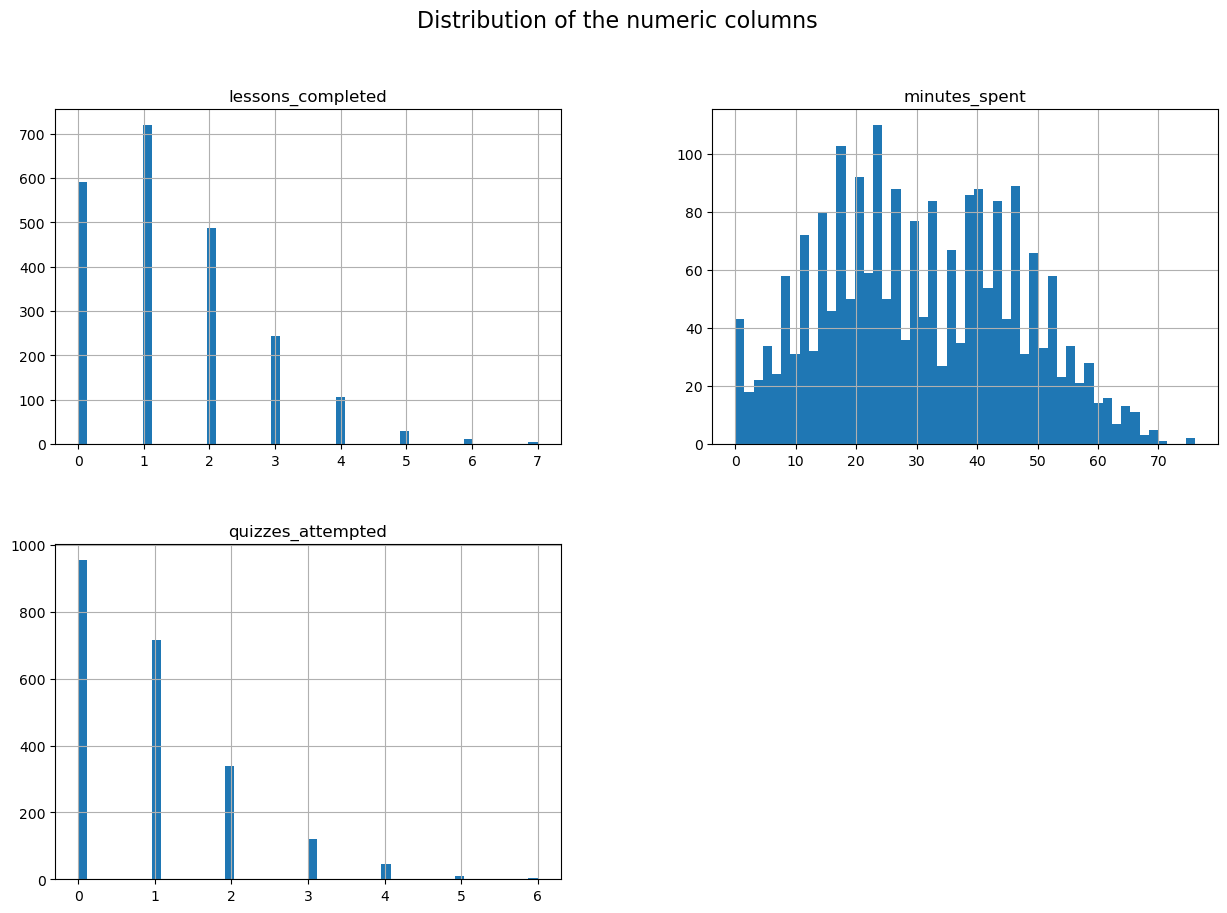

In [8]:
data[cols].hist(bins=50, figsize=(15,10))
plt.suptitle('Distribution of the numeric columns', fontsize=16)
plt.show()


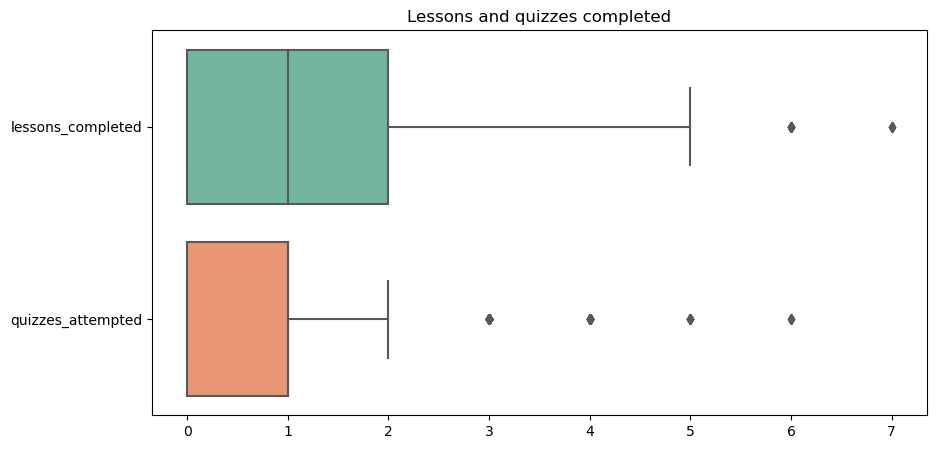

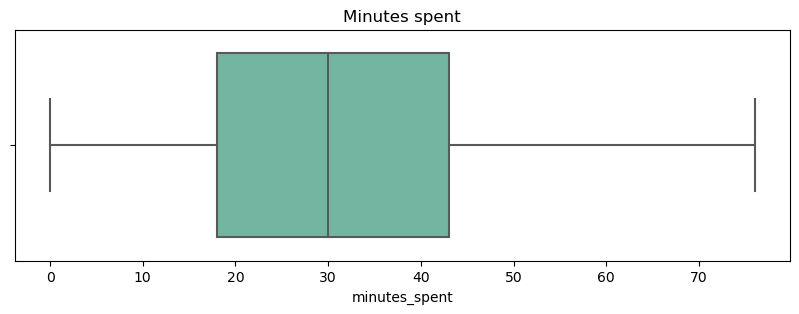

In [9]:
# Figura 1:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data[['lessons_completed', 'quizzes_attempted']], orient='h', palette='Set2')
plt.title('Lessons and quizzes completed')
plt.show()

# Figura: 2
plt.figure(figsize=(10, 3))
sns.boxplot(x=data['minutes_spent'], orient='h', palette='Set2')
plt.title('Minutes spent')
plt.show()

Students who complete more than 5 lessons per day are considered atypical learners.  

Students who finish more than 2 quizzes per day are considered atypical learners.

In [10]:
corr_matriz = data[cols].corr(numeric_only=True)
corr_matriz

,lessons_completed,minutes_spent,quizzes_attempted
lessons_completed,1.000000,0.261285,0.173309
minutes_spent,0.261285,1.000000,0.341176
quizzes_attempted,0.173309,0.341176,1.000000


In [11]:
cov_matriz = data[cols].cov(numeric_only=True)
cov_matriz

,lessons_completed,minutes_spent,quizzes_attempted
lessons_completed,1.617661,5.284023,0.231941
minutes_spent,5.284023,252.820436,5.708176
quizzes_attempted,0.231941,5.708176,1.107197


There is no STRONG relationship between the minutes spent per day and the number of quizzes or lessons completed. However, if a student increases their time spent on the app, these variables will show a growing dependency — that is, the more time a student dedicates to the app, the higher the number of quizzes and lessons completed per day.

## 3.2 Summary table.

In [12]:
resume_data = data.groupby('user_id').agg({
    'lessons_completed': 'sum',
    'minutes_spent': 'sum',
    'quizzes_attempted': 'sum',
    'subscription_type': 'last',
    'date': 'nunique'  
}).reset_index().rename(columns={'date': 'days_active'}) 

resume_data

,user_id,lessons_completed,minutes_spent,quizzes_attempted,subscription_type,days_active
0,1,17,335,6,Gratuito,23
1,2,42,1094,24,Premium,25
2,3,25,529,14,Gratuito,24
3,4,18,414,10,Gratuito,23
4,5,20,483,7,Gratuito,21
...,...,...,...,...,...,...
95,96,24,410,15,Gratuito,24
96,97,25,436,12,Gratuito,26
97,98,24,453,18,Gratuito,23
98,99,42,1065,46,Premium,24


In [13]:
days_active = data.groupby('user_id')['date'].nunique()
days_active

user_id
1      23
2      25
3      24
4      23
5      21
       ..
96     24
97     26
98     23
99     24
100    23
Name: date, Length: 100, dtype: int64

## 3.3 Streak calculation

In [14]:
#We define a time series:
serie_time = data[['user_id','date']].copy()
serie_time['date'] = pd.to_datetime(serie_time['date'], format='%Y-%m-%d')
serie_time

,user_id,date
0,1,2024-01-01
1,1,2024-01-03
2,1,2024-01-04
3,1,2024-01-05
4,1,2024-01-06
...,...,...
2187,100,2024-01-26
2188,100,2024-01-27
2189,100,2024-01-28
2190,100,2024-01-29


In [15]:
# We calculate the difference in days between the previous record and the current one.
serie_time['date_diff'] = serie_time.groupby('user_id')['date'].diff().dt.days
serie_time

,user_id,date,date_diff
0,1,2024-01-01,NaN
1,1,2024-01-03,2.0
2,1,2024-01-04,1.0
3,1,2024-01-05,1.0
4,1,2024-01-06,1.0
...,...,...,...
2187,100,2024-01-26,1.0
2188,100,2024-01-27,1.0
2189,100,2024-01-28,1.0
2190,100,2024-01-29,1.0


In [16]:
#We record boolean values to analyze the start of streaks per user  
#(serie_time['user_id'] != serie_time['user_id'].shift(1): Helps identify user changes

serie_time['new_streak'] = (serie_time['date_diff'] != 1) | (serie_time['user_id'] != serie_time['user_id'].shift(1)) 
serie_time

,user_id,date,date_diff,new_streak
0,1,2024-01-01,NaN,True
1,1,2024-01-03,2.0,True
2,1,2024-01-04,1.0,False
3,1,2024-01-05,1.0,False
4,1,2024-01-06,1.0,False
...,...,...,...,...
2187,100,2024-01-26,1.0,False
2188,100,2024-01-27,1.0,False
2189,100,2024-01-28,1.0,False
2190,100,2024-01-29,1.0,False


In [17]:
#Calculation of the number of streaks by assigning IDs to new streaks.
serie_time['streak_id'] = serie_time.groupby('user_id')['new_streak'].cumsum() 
serie_time.head(10)

,user_id,date,date_diff,new_streak,streak_id
0,1,2024-01-01,NaN,True,1
1,1,2024-01-03,2.0,True,2
2,1,2024-01-04,1.0,False,2
3,1,2024-01-05,1.0,False,2
4,1,2024-01-06,1.0,False,2
5,1,2024-01-07,1.0,False,2
6,1,2024-01-08,1.0,False,2
7,1,2024-01-10,2.0,True,3
8,1,2024-01-11,1.0,False,3
9,1,2024-01-12,1.0,False,3


In [18]:
#Calculations of streak lengths (how many days each streak lasted) per user.
streaks = serie_time.groupby(['user_id','streak_id']).size().reset_index(name='streak_lenght')
streaks

,user_id,streak_id,streak_lenght
0,1,1,1
1,1,2,6
2,1,3,8
3,1,4,1
4,1,5,1
...,...,...,...
666,100,2,6
667,100,3,5
668,100,4,3
669,100,5,7


In [19]:
# Summary of results
def moda(serie):
    modas = serie.mode()
    if modas.empty:
        return None
    else:
        return modas.iloc[0]

streak_resumen = streaks.groupby('user_id').agg(
    streak_Min=('streak_lenght', 'min'),
    streak_Max=('streak_lenght', 'max'),
    streak_Mode=('streak_lenght', moda),
    strek_Average=('streak_lenght', 'mean')
).reset_index()
streak_resumen = streak_resumen.round(0)
streak_resumen

,user_id,streak_Min,streak_Max,streak_Mode,strek_Average
0,1,1,8,1,3.0
1,2,1,12,4,5.0
2,3,2,7,2,4.0
3,4,1,8,2,3.0
4,5,1,11,1,3.0
...,...,...,...,...,...
95,96,3,14,3,8.0
96,97,1,15,1,4.0
97,98,1,8,1,5.0
98,99,1,7,3,4.0


## 3.4 Summary table of user activity

In [20]:
user_actResume = resume_data.merge(streak_resumen, on= 'user_id', how='left')
user_actResume

,user_id,lessons_completed,minutes_spent,quizzes_attempted,subscription_type,days_active,streak_Min,streak_Max,streak_Mode,strek_Average
0,1,17,335,6,Gratuito,23,1,8,1,3.0
1,2,42,1094,24,Premium,25,1,12,4,5.0
2,3,25,529,14,Gratuito,24,2,7,2,4.0
3,4,18,414,10,Gratuito,23,1,8,2,3.0
4,5,20,483,7,Gratuito,21,1,11,1,3.0
...,...,...,...,...,...,...,...,...,...,...
95,96,24,410,15,Gratuito,24,3,14,3,8.0
96,97,25,436,12,Gratuito,26,1,15,1,4.0
97,98,24,453,18,Gratuito,23,1,8,1,5.0
98,99,42,1065,46,Premium,24,1,7,3,4.0


## 3.6 Monthly analysis

In [21]:
columns = list(user_actResume.columns[1:4]) + ['days_active','strek_Average']

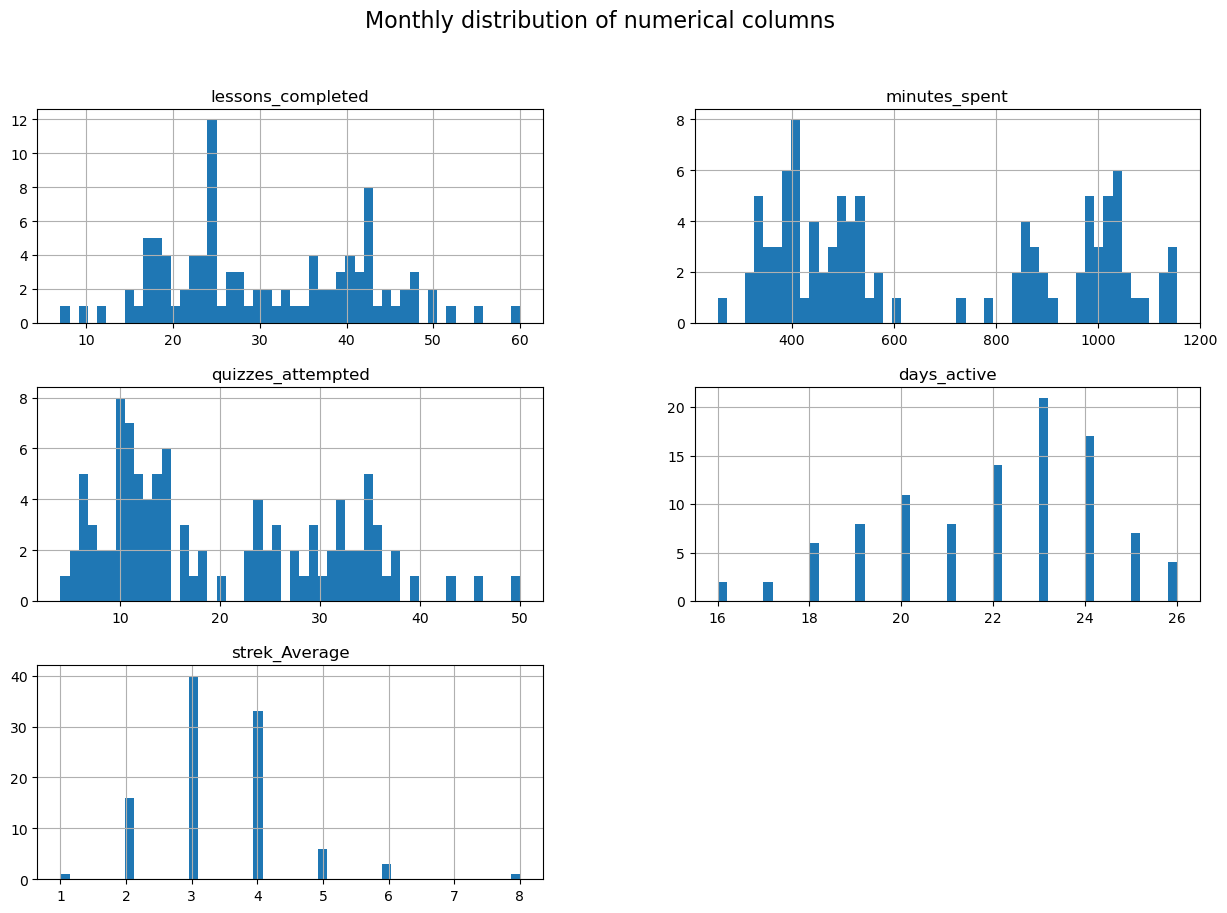

In [22]:
user_actResume[columns].hist(bins=50, figsize=(15,10))
plt.suptitle('Monthly distribution of numerical columns', fontsize=16)
plt.show()

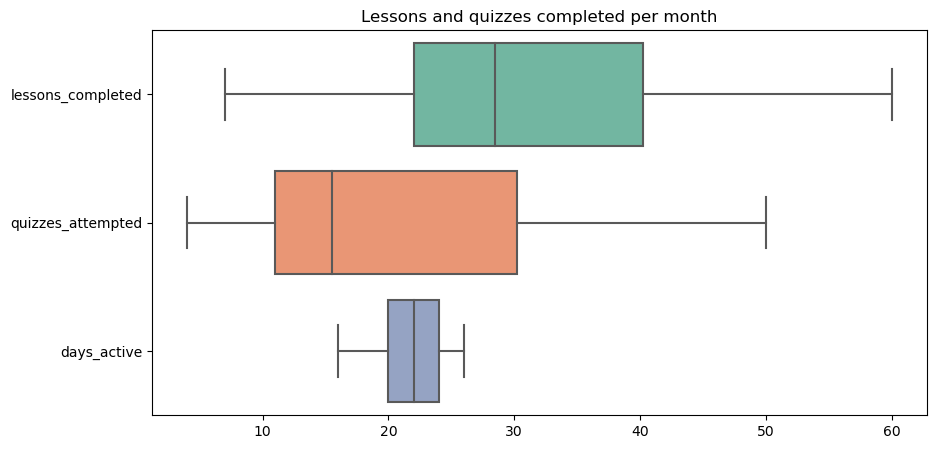

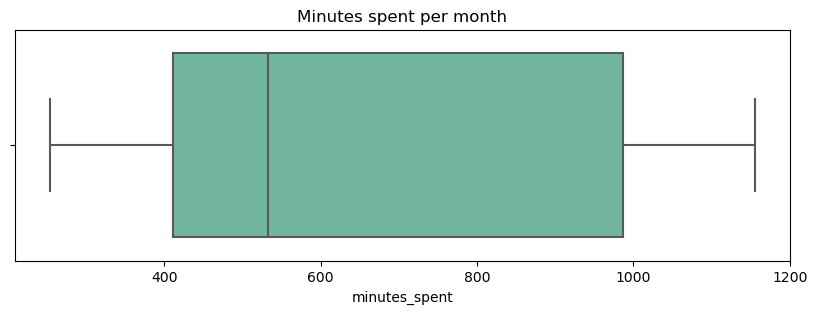

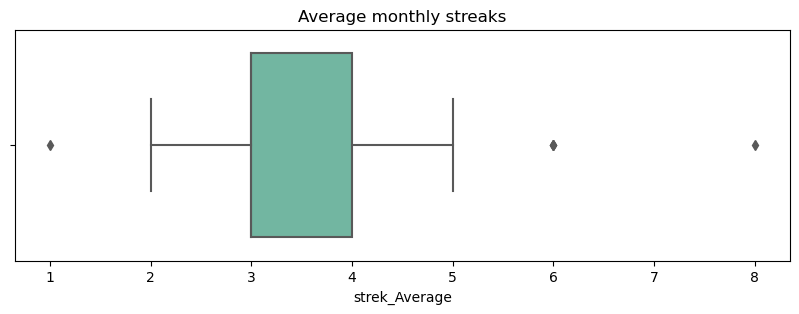

In [23]:
# Figura 1:
plt.figure(figsize=(10, 5))
sns.boxplot(data=user_actResume[['lessons_completed', 'quizzes_attempted','days_active']], orient='h', palette='Set2')
plt.title('Lessons and quizzes completed per month')
plt.show()

# Figura: 2
plt.figure(figsize=(10, 3))
sns.boxplot(x=user_actResume['minutes_spent'], orient='h', palette='Set2')
plt.title('Minutes spent per month')
plt.show()

# Figura: 3
plt.figure(figsize=(10, 3))
sns.boxplot(x=user_actResume['strek_Average'], orient='h', palette='Set2')
plt.title('Average monthly streaks')
plt.show()

Students who, on average, only manage to maintain a 1-day streak are considered atypical, which indicates that most students tend to be continuously active on the app.

Students who maintain streaks longer than 5 days are also considered atypical.

In [24]:
#Numeric
user_actResume[columns].describe()

,lessons_completed,minutes_spent,quizzes_attempted,days_active,strek_Average
count,100.00000,100.000000,100.000000,100.000000,100.000000
mean,30.91000,674.490000,20.160000,21.920000,3.410000
std,11.43457,286.203978,11.275897,2.372741,1.064534
min,7.00000,254.000000,4.000000,16.000000,1.000000
25%,22.00000,410.750000,11.000000,20.000000,3.000000
50%,28.50000,532.500000,15.500000,22.000000,3.000000
75%,40.25000,986.500000,30.250000,24.000000,4.000000
max,60.00000,1155.000000,50.000000,26.000000,8.000000


Conclusions:

- 75% of students complete fewer than 40 lessons per month  
- 75% of students spend less than 16 hours studying (using the app) per month  
- 75% of students complete fewer than 30 quizzes per month  
- 75% of students remain active fewer than 24 days per month  
- 75% of students maintain streaks shorter than 4 days

In [25]:
# Category
user_actResume['subscription_type'].describe()

count          100
unique           2
top       Gratuito
freq            56
Name: subscription_type, dtype: object

56% of students have a Free subscription.

## 3.5 Analysis by subscription type

In [26]:
#First, we will analyze whether any user changed their subscription type on any day of the month:

cambio_subs = data[['user_id', 'subscription_type']].drop_duplicates() 

if not(cambio_subs.user_id.duplicated().any()):
    print('There were no subscription changes.') 

There were no subscription changes.


We are interested in knowing whether there is any difference between users with premium and free subscriptions. 

This analysis will help us consider this variable in future models.

In [27]:
import scipy.stats as stats

free = user_actResume[user_actResume['subscription_type'] == 'Gratuito']
premium = user_actResume[user_actResume['subscription_type'] == 'Premium']

for var in columns:
    # test Mann-Whitney
    stat, p = stats.mannwhitneyu(free[var], premium[var], alternative='two-sided')
    
    # Effect size calculation (r)
    n1, n2 = len(free[var].dropna()), len(premium[var].dropna())
    mean_U = n1 * n2 / 2
    std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z = (stat - mean_U) / std_U
    r = abs(z) / np.sqrt(n1 + n2)
    
    # Result
    print(f"{var:<20} | U={stat:>10.2f} | p-value={p:>8.4f} | r={r:>6.3f}")


lessons_completed    | U=      6.50 | p-value=  0.0000 | r= 0.851
minutes_spent        | U=      0.00 | p-value=  0.0000 | r= 0.856
quizzes_attempted    | U=      5.00 | p-value=  0.0000 | r= 0.852
days_active          | U=   1233.50 | p-value=  0.9944 | r= 0.001
strek_Average        | U=   1368.50 | p-value=  0.3184 | r= 0.095


We conclude that for the variables:  
- lessons_completed  
- minutes_spent 
- quizzes_attempted

There is a significant difference between Premium and Free users, with a strong effect size (\( r \approx 0.8 \)).  
In conclusion, users with `Premium` and `Free` subscriptions are significantly different.

It makes sense to include the variable `subscription_type` in our model.

# 4. KMeans

For the development of this model, we will focus on the following variables:

- lessons_completed	
- minutes_spent	
- quizzes_attempted	
- subscription_type	
- days_active 
- strek_Average

In [28]:
# We retrieve the data from the summary table
data_model = user_actResume[['user_id','lessons_completed', 
                             'minutes_spent', 
                             'quizzes_attempted', 
                             'subscription_type', 
                             'days_active',
                             'strek_Average'
                             ]].copy()

data_model = data_model.set_index('user_id')
data_model.head(4)

,lessons_completed,minutes_spent,quizzes_attempted,subscription_type,days_active,strek_Average
user_id,,,,,,
1,17,335,6,Gratuito,23,3.0
2,42,1094,24,Premium,25,5.0
3,25,529,14,Gratuito,24,4.0
4,18,414,10,Gratuito,23,3.0


In [29]:
#Preprocessing the table
from sklearn.preprocessing import StandardScaler

# We convert categorical variables to numerical ones
data_model.replace({'Gratuito': 1,'Premium':0}, inplace=True)


escalador = StandardScaler()
data_normalizado = escalador.fit_transform(data_model)

# Convert to DataFrame
data_estandar = pd.DataFrame(data_normalizado, 
                                index=data_model.index, 
                                columns=data_model.columns)

## 4.1 Hyperparameter Optimization (Elbow Plot)

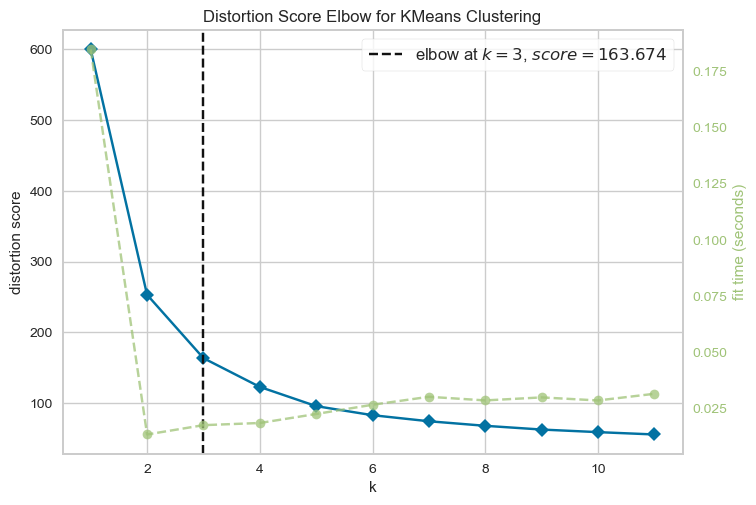

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

modelos = KMeans(n_init=10,random_state=42)

visualizer = KElbowVisualizer(modelos, k=(1,12)) 


visualizer.fit(data_estandar)
visualizer.show()

It is optimal to set $ K = 3 $

## 4.2 Model

In [31]:
k_medias = KMeans(n_clusters = 3 ,init='k-means++',max_iter=300, 
                          random_state= 111  , algorithm='elkan')

In [32]:
k_medias.fit(data_estandar)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,111
,copy_x,True
,algorithm,'elkan'


In [33]:
data_estandar['cluster'] = k_medias.labels_
data_model['cluster'] = k_medias.labels_

data_model.head(10)

,lessons_completed,minutes_spent,quizzes_attempted,subscription_type,days_active,strek_Average,cluster
user_id,,,,,,,
1,17,335,6,1,23,3.0,2
2,42,1094,24,0,25,5.0,1
3,25,529,14,1,24,4.0,2
4,18,414,10,1,23,3.0,2
5,20,483,7,1,21,3.0,0
6,48,997,24,0,22,3.0,1
7,33,536,10,1,25,5.0,2
8,23,386,18,1,21,3.0,0
9,36,860,24,0,20,3.0,1


In [ ]:
# Statistics by classification
cluster_profile = data_model.groupby('cluster').agg({
    'lessons_completed': ['max','min','mean'],
    'minutes_spent': ['max','min','mean'],
    'quizzes_attempted': ['max','min','mean'],
   'days_active': ['max','min','mean'],
    'strek_Average': ['max','min','mean']
}).reset_index()

cluster_profile['class'] = ['Bajo','Intensivos','Moderado']
cluster_profile

cluster lessons_completed                minutes_spent                   \
                        max min       mean           max  min        mean   
0       0                27   7  19.285714           483  254  369.238095   
1       1                60  30  42.045455          1155  730  979.727273   
2       2                33  15  23.885714           602  330  473.914286   

  quizzes_attempted                days_active                strek_Average  \
                max min       mean         max min       mean           max   
0                18   5   9.095238          22  16  19.047619           3.0   
1                50  16  31.431818          26  17  22.000000           5.0   
2                20   4  12.628571          26  21  23.542857           8.0   

                       class  
   min      mean              
0  1.0  2.428571        Bajo  
1  2.0  3.250000  Intensivos  
2  3.0  4.200000    Moderado

We have segmented our users into 3 groups based on their activity in the app:

- **Low**:  
  - Students with a monthly average of:  
    - 19 lessons completed  
    - 369 minutes invested (6 hours)  
    - 9 quizzes attempted  
    - 19 active days  
    - 2-day streak  

- **Moderate**:  
  - Students with a monthly average of:  
    - 23 lessons completed  
    - 474 minutes invested (7 hours)  
    - 12 quizzes attempted  
    - 23 active days  
    - 4-day streak  

- **Intensive**:  
  - Students with a monthly average of:  
    - 42 lessons completed  
    - 980 minutes invested (16 hours)  
    - 31 quizzes attempted  
    - 22 active days  
    - 3-day streak

In [ ]:
# We save the model and the scaler
import joblib

joblib.dump(k_medias, "kmeans_segmentacion_estudiantes_2025-21-10.pkl")
joblib.dump(escalador, "scaler_metricas_actividad_estudiantes_2025-21-10.pkl")

In [ ]:
# We save the monthly summary
data_model.to_csv(f'resumen_actividad_usuario_mensual.csv', index=False)